In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
from numpy import pi, sqrt, cos, sin, radians, arcsin
%matplotlib widget

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

In [19]:
# encoder_file = max(glob.glob(f"{root_dir}/{trial}/data/*encoder.txt"), key=os.path.getctime)
# force_file = max(glob.glob(f"{root_dir}/{trial}/data/*force.txt"), key=os.path.getctime)

df_encoder = pd.read_csv('spring2_encoder.csv')
df_encoder2 = pd.read_csv('spring2_encoder2.csv')

force_file = 'spring2_force.txt'
force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)
force_file2 = 'spring2_force2.txt'
force_data_path2 = force_file2[:-4] + '_filt.txt'
remove_even_lines(force_file2, force_data_path2)
df_force2 = extract_from_txt(
    force_data_path2, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force2.loc[:,'time'] = np.cumsum(df_force2['looptime']) / 1e6
df_encoder['time'] = df_encoder['micros']/1e6
df_encoder2['time'] = df_encoder2['micros']/1e6

df_encoder['encoder'] = (df_encoder['encoder'] + 2**13) % 2**14
# df_encoder2['encoder'] = (df_encoder2['encoder'] + 2**13) % 2**14

display(df_force, df_encoder)

,elapsed,looptime,N23,N67,time
0,5672.0,665.0,-0.096847,0.338718,0.000665
1,5673.0,659.0,-0.253305,0.372160,0.001324
2,5674.0,662.0,-0.165662,0.337305,0.001986
3,5674.0,661.0,-0.047724,0.290946,0.002647
4,5675.0,661.0,0.055826,0.219206,0.003308
...,...,...,...,...,...
101785,73048.0,662.0,13.671576,0.220326,67.370399
101786,73048.0,662.0,13.688057,0.239261,67.371061
101787,73049.0,662.0,13.598877,0.259106,67.371723
101788,73050.0,662.0,13.534639,0.276916,67.372385


,micros,encoder,time
0,2904.0,8195.0,0.002904
1,6168.0,8192.0,0.006168
2,9456.0,8192.0,0.009456
3,12740.0,8194.0,0.012740
4,16052.0,8195.0,0.016052
...,...,...,...
14705,51899444.0,8226.0,51.899444
14706,51902924.0,8223.0,51.902924
14707,51906404.0,8227.0,51.906404
14708,51909888.0,8226.0,51.909888


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


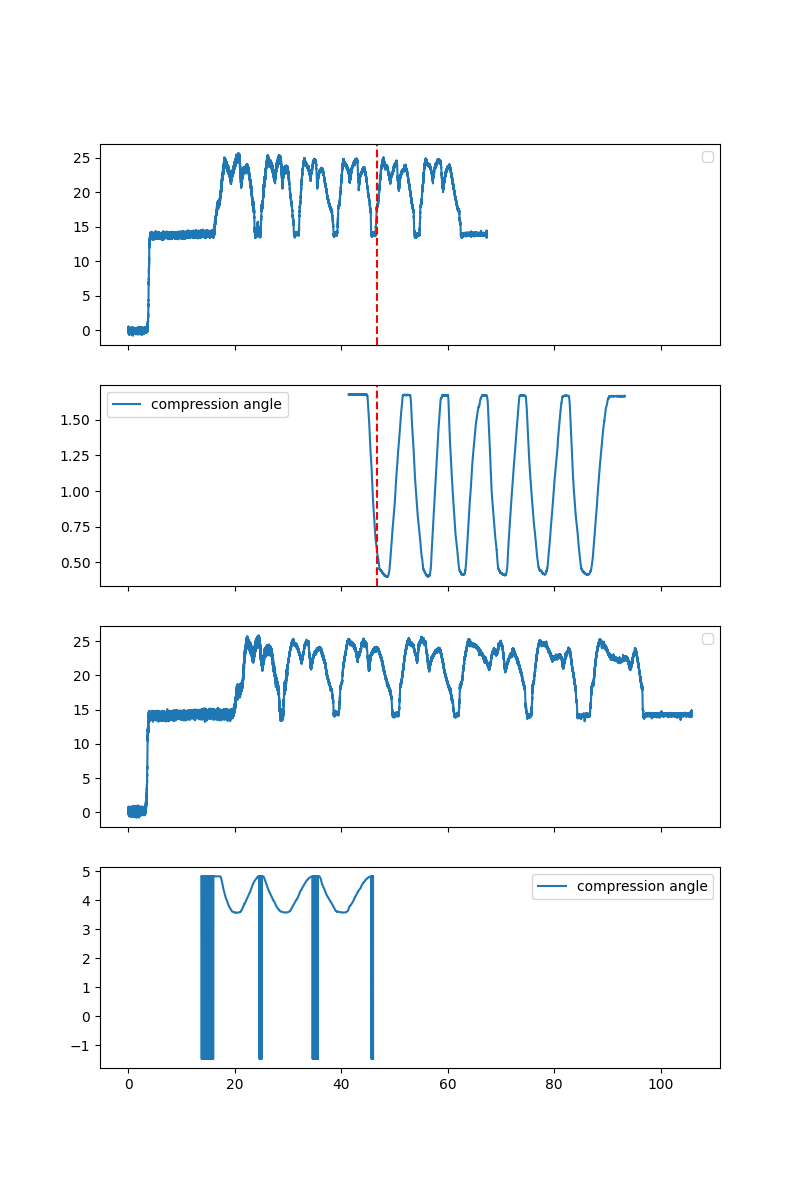

In [23]:
angle_init = radians(96.12)

df_encoder['angle'] = angle_init - radians(df_encoder['encoder']/(2**14) * 360 - 180)
df_encoder['time_adj'] = df_encoder['time'] + 41.4
df_encoder2['angle'] = angle_init - radians(df_encoder2['encoder']/(2**14) * 360 - 180)
df_encoder2['time_adj'] = df_encoder['time'] + 13.8

# df_encoder2 = df_encoder2[df_encoder2['time_adj'] < 46]


from scipy.interpolate import interp1d
interpolator = interp1d(df_force['time'], df_force['N23'], fill_value="extrapolate")
df_encoder['N23_interp'] = interpolator(df_encoder['time_adj'])
interpolator2 = interp1d(df_force2['time'], df_force2['N23'], fill_value="extrapolate")
df_encoder2['N23_interp'] = interpolator2(df_encoder2['time_adj'])

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,12))
axs[0].plot(df_force['time'], df_force['N23'])
# axs[0].plot(df_encoder['time_adj'], df_encoder['N23_interp'], label='force')
axs[1].plot(df_encoder['time_adj'], df_encoder['angle'], label='compression angle')
# axs[1].legend()
axs[0].axvline(46.8, linestyle='dashed', color='red')
axs[1].axvline(46.8, linestyle='dashed', color='red')
# axs[1].axvline(46.8)

axs[2].plot(df_force2['time'], df_force2['N23'])
# axs[2].plot(df_encoder2['time_adj'], df_encoder2['N23_interp'], label='force')
axs[3].plot(df_encoder2['time_adj'], df_encoder2['angle'], label='compression angle')
# axs[3].legend()

for ax in axs:
    ax.legend()




0.6111648473124223


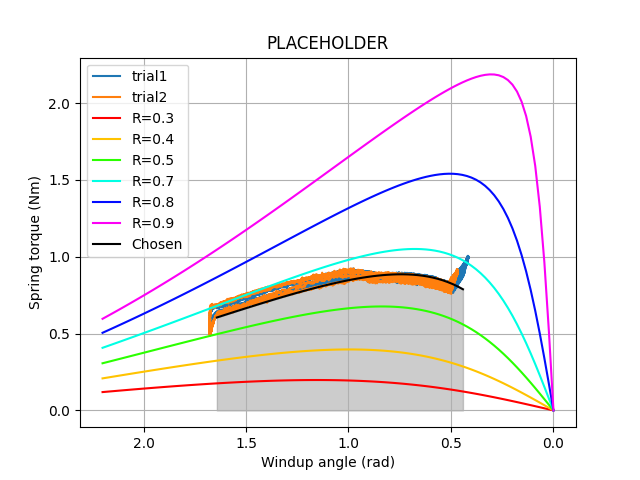

In [112]:
plt.figure()

L1 = 0.057896
theta_start = radians(94.1)
theta_end = radians(94.1 - 68.8)
thetas = np.linspace(2.2, 0, 100)
L0 = 0.085
n_springs = 6
k = 43*n_springs
F0 = 5*n_springs

L2_real = 0.035384
R_real = L2_real/L1
print(R_real)

plt.plot(df_encoder['angle'], df_encoder['N23_interp'] * L2_real, label='trial1')
plt.plot(df_encoder2['angle'], df_encoder2['N23_interp'] * L2_real, label='trial2')

# L2 = 35.384
for R in np.linspace(0.3, 0.9, 6):
    L2 = R*L1
    L1_rescale = L1

    Ls = sqrt(L1_rescale**2 + L2**2 - 2*L1_rescale*L2*cos(thetas))
    Fs = k*(L0 - Ls) + F0
    # phis = arcsin()
    Ts = Fs *L2 * L2*sin(thetas)/Ls
    T_norms = Ts/max(Ts)

    # plt.plot(thetas, Ls, label='Spring length (mm)')

    color = plt.cm.hsv(R*1.5-0.5)  # Use a red-blue colormap to vary color based on R
    # plt.plot(thetas, Fs, label=f"{R:.2f}", color=color)
    plt.plot(thetas, Ts, label=f"R={R:.1f}", color=color)


thetas = np.linspace(theta_start, theta_end, 50)
L2 = R_real * L1
Ls = sqrt(L1**2 + L2**2 - 2*L1*L2*cos(thetas))
Fs = k*(L0 - Ls) + F0
phis = arcsin(L2*sin(thetas)/Ls)
Ts = Fs*L2*sin(phis)
T_norms = Ts/max(Ts)
plt.plot(thetas, Ts, label=f"Chosen", color='black')


x_fill = thetas[(thetas <= theta_start) & (thetas >= theta_end)]
y_fill = Ts[(thetas <= theta_start) & (thetas >= theta_end)]
plt.fill_between(x_fill, y_fill, color='gray', alpha=0.4)







# plt.ylim(ymin=0, ymax=50)
plt.xlabel('Windup angle (rad)')
plt.ylabel('Spring torque (Nm)')
plt.title('PLACEHOLDER')
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()




In [35]:
max(df_force['N23'])

28.4242973328